# Featurization

- Featurize every dataset once using all possible featurizers
- This is a deterministic operation, hence we can run it once and store it
- None is passed for all external software featurizers (PaDEL, AlvaDesc, ...)

### Initialization

In [1]:
import sys
import numpy as np
from pathlib import Path
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer
from molfeat.trans.pretrained import GraphormerTransformer, PretrainedDGLTransformer
from molfeat.trans.base import MoleculeTransformer
from molfeat.calc.pharmacophore import Pharmacophore2D
from molfeat.trans.fp import FPVecTransformer

# Enable relative import
current_dir = Path().resolve()
sys.path.append(str(current_dir.parent))
from topolearn.representations import *
from topolearn.datasets import *

featurizers = {
    # Pretrained deep learning / general embedding
    "ChemBERTa": PretrainedHFTransformer(kind='ChemBERTa-77M-MTR', notation='smiles', dtype=float),
    "ChemGPT": PretrainedHFTransformer(kind='ChemGPT-19M', notation='selfies', dtype=float),
    "SafeGPT": SAFEMolTransformer(pooling="gpt", concat_layers=[-1]),
    "MoLFormer-XL": PretrainedHuggingfaceTransformer("ibm/MoLFormer-XL-both-10pct"),
    "Graphormer": GraphormerTransformer(kind='pcqm4mv2_graphormer_base', dtype=float),
    "GIN": PretrainedDGLTransformer(kind='gin_supervised_masking', dtype=float),
    "Mol2Vec": Mol2VecFeaturizer(),
    "RAND": RandomFeaturizer(),
    
    # Bit vector
    "AVALON": FPVecTransformer(kind='avalon', length=1024, dtype=float),
    "CATS2D": FPVecTransformer("cats2D", length=1024, dtype=np.float32),
    "ECFP4": FPVecTransformer(kind='ecfp:4', length=1024, dtype=float),
    "MACCS": MACCSFingerprint(),
    "MAP4": MAP4Featurizer(),
    "EState": None,
    "PubChem": None,
    "KR": None,
    "RDKit": FPVecTransformer(kind='rdkit', length=1024, dtype=float),
    "Pharm2D": MoleculeTransformer(featurizer=Pharmacophore2D(factory='gobbi', length=1024), dtype=float),

    # Descriptors
    "TOPO": None,
    "RingDesc": None,
    "FGCount": None,
    "2DAP": None,
    "ConstIdx": None,
    "MolProp": None,
    "WalkPath": None
}

datasets = [load_adra1a_regression(return_mask=True), 
            load_alox5ap_regression(return_mask=True),
            load_atr_regression(return_mask=True),
            load_jak1_regression(return_mask=True),
            load_jak2_regression(return_mask=True),
            load_musc1_regression(return_mask=True),
            load_musc2_regression(return_mask=True),
            load_kor_regression(return_mask=True),
            load_lipo_regression(return_mask=True),
            load_hlmc_regression(return_mask=True),
            load_sol_regression(return_mask=True),
            load_dpp4_regression(return_mask=True)]

2025-01-19 12:32:11.091258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 12:32:16.917425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-01-19 12:32:37 | WARNING | deepchem.feat.molecule_featurizers.rdkit_descriptors | No normalization for SPS. Feature removed!
2025-01-19 12:32:37 | WARNING | deepchem.feat.molecule_featurizers.rdkit_descriptors | No normalization for AvgIpc. Feature removed!
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


2025-01-19 12:32:38 | WARNING | tensorflow | From /home/rottach/phd/.phd/lib/python3.11/site-packages/tensorflow/python/util/deprecation.py:588: calling function (from tensorflow.python.eager.polymorphic_function.polymorphic_function) with experimental_relax_shapes is deprecated and will be removed in a future version.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
2025-01-19 12:32:45 | WARNING | deepchem.models | Skipped loading some Jax models, missing a dependency. No module named 'jax'
2025-01-19 12:32:50 | WARNING | google.auth.compute_engine._metadata | Compute Engine Metadata server unavailable on attempt 1 of 3. Reason: timed out
2025-01-19 12:32:53 | WARNING | google.auth.compute_engine._metadata | Compute Engine Metadata server unavailable on attempt 2 of 3. Reason: timed out
2025-01-19 12:32:56 | WARNING | google.auth.com

### Featurization

**Note**: It is not needed to run this code if the processed features are already available (which they are in the repository)

In [11]:
import os

# Map externally processed filenames to new names
processed_mapping = {"2DAP": '2D_atom_pairs.tsv', 	 
                     "ConnectIdx": 'connectivity_indices.tsv',   
                     "ConstIdx": 'constitutional_indices.tsv',   
                     "FGCount": 'functional_group_counts.tsv', 
                     "MolProp": 'molecular_properties.tsv', 
                     "KR": 'Standardized_pH7.csv', 	
                     "PubChem": 'Standardized_pH7.csv',   
                     "EState": 'Standardized_pH7.csv',   
                     "RingDesc": 'ring_descriptors.tsv',    
                     "TOPO": 'topological_indices.tsv', 
                     "WalkPath": 'walk_and_path_counts.tsv'}

# Path of the externally processed features
processed_path = Path("../data/external")
save_path = Path("../data/features/")

dataset_shapes = []
representation_shapes = []

for dataset, dataset_mask in datasets:
    per_dataset_data_shapes = []
    per_dataset_rep_shapes = []
    
    # Create new folder for featurized data
    dataset_name = dataset.iloc[0]['dataset']
    os.makedirs(save_path / Path(f"{dataset_name}"), exist_ok=True)

    # Canonical smiles
    dataset["smiles"] = dataset["smiles"].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

    for featurizer in featurizers.keys():
        save_file = save_path / Path(f"{dataset_name}/{dataset_name}_{featurizer}.pkl")
        
        if os.path.exists(save_file):
            loaded = pd.read_pickle(save_file)
            print(f"File {save_file} has already been created. (shape: {loaded.shape})")
            per_dataset_data_shapes.append(loaded.shape[0])
            per_dataset_rep_shapes.append(loaded.shape[1])
            continue
        
        # Target and compound columns
        y = dataset["target"].values
        sm = dataset["smiles"]

        # Externally processed features
        if featurizers[featurizer] == None:
            feature_filename = processed_mapping[featurizer]
            print(f"Loading features for {feature_filename} on dataset {dataset_name}")
            if feature_filename.endswith(".tsv"):
                features = pd.read_csv(f"{processed_path}/{dataset_name}_{feature_filename}", sep="\t")
            else:
                features = pd.read_csv(f"{processed_path}/{dataset_name}_{feature_filename}")
            if feature_filename == "Standardized_pH7.csv":
                if featurizer == "KR" or featurizer == "EState":
                    features = features[[col for col in features.columns if featurizer in col]]
                else:
                    features = features[[col for col in features.columns if "Pubchem" in col]]

            # Save features
            na_cols = features.columns[(features == "na").any()].tolist()
            nan_cols = features.columns[features.isna().any()].tolist()

            if len(na_cols) > 0:
                print("Columns with na: ", na_cols)

            if len(nan_cols) > 0:
                print("Columns with nan: ", nan_cols)

            X = features.select_dtypes(include=['float64', 'int64'])
            if "No." in X.columns:
                X = X.drop(columns=["No."])

            X = X[dataset_mask].reset_index(drop=True)
            X["smiles"] = sm
            X["target"] = y
            X.to_pickle(save_file)
            print(f"Created {save_file} with shape: {X.shape})")
            assert X["smiles"].isna().sum() == 0
            per_dataset_data_shapes.append(X.shape[0])
            per_dataset_rep_shapes.append(X.shape[1])

        # Compute features
        else:
            print(f"Processing {featurizer} on dataset {dataset_name}")
            X = np.array(featurizers[featurizer](dataset["smiles"])).squeeze()
            df = pd.DataFrame(X)
            df["target"] = y
            df["smiles"] = sm
            df.to_pickle(save_file)
            per_dataset_data_shapes.append(df.shape[0])
            per_dataset_rep_shapes.append(df.shape[1])
    
    # Create "DESC_ALL" featureset  
    desc_all_file = save_path / Path(f"{dataset_name}/{dataset_name}_Combined.pkl")
    if not os.path.exists(desc_all_file): 
        descs = ["TOPO", "RingDesc", "FGCount", "2DAP", "ConstIdx", "MolProp", "WalkPath", "MolProp2"]
        concat_dfs = []
        for i, desc in enumerate(descs):
            file = save_path / Path(f"{dataset_name}/{dataset_name}_{desc}.pkl")
            if i > 0:
                tmp = pd.read_pickle(file).drop(["target", "smiles"], axis=1)
            else:
                tmp = pd.read_pickle(file)
            concat_dfs.append(tmp)
        desc_all = pd.concat(concat_dfs, axis=1)
        desc_all.to_pickle(desc_all_file)
        print([df.shape for df in concat_dfs])

    dataset_shapes.append(per_dataset_data_shapes)
    representation_shapes.append(per_dataset_rep_shapes)

File ../data/features/ADRA1A/ADRA1A_ChemBERTa.pkl has already been created. (shape: (2847, 386))
File ../data/features/ADRA1A/ADRA1A_ChemGPT.pkl has already been created. (shape: (2847, 258))
File ../data/features/ADRA1A/ADRA1A_SafeGPT.pkl has already been created. (shape: (2847, 770))
File ../data/features/ADRA1A/ADRA1A_MoLFormer-XL.pkl has already been created. (shape: (2847, 770))
File ../data/features/ADRA1A/ADRA1A_Graphormer.pkl has already been created. (shape: (2847, 770))
File ../data/features/ADRA1A/ADRA1A_GIN.pkl has already been created. (shape: (2847, 302))
File ../data/features/ADRA1A/ADRA1A_Mol2Vec.pkl has already been created. (shape: (2847, 302))
File ../data/features/ADRA1A/ADRA1A_RAND.pkl has already been created. (shape: (2847, 130))
File ../data/features/ADRA1A/ADRA1A_AVALON.pkl has already been created. (shape: (2847, 1026))
File ../data/features/ADRA1A/ADRA1A_CATS2D.pkl has already been created. (shape: (2847, 191))
File ../data/features/ADRA1A/ADRA1A_ECFP4.pkl ha

### Sanity checks

- All representations must have same number of features
- All datasets must have the same number of samples
- For some representations, nan-columns are removed, resulting in slightly less features depending on the molecular data.

In [8]:
def all_same(lst):
    return all(x == lst[0] for x in lst)

for i, ds in enumerate(dataset_shapes):
    if not all_same(ds):
        print(f"Issue with dataset shape for {i}: ", ds)


per_rep_type = np.array(representation_shapes).transpose().tolist()
for j, rs in enumerate(per_rep_type):
    if not all_same(rs):
        print(f"Issue with representation shape for {j}: ", rs, list(featurizers.keys())[j])


Issue with representation shape for 18:  [76, 77, 79, 77, 77, 75, 75, 75, 76, 76, 76, 76] TOPO
Issue with representation shape for 22:  [52, 52, 52, 52, 50, 50, 52, 52, 50, 52, 52, 50] ConstIdx
Issue with representation shape for 23:  [23, 24, 26, 26, 24, 21, 21, 21, 21, 26, 26, 21] MolProp


Check target distributions

Dataset:  Alpha-1A


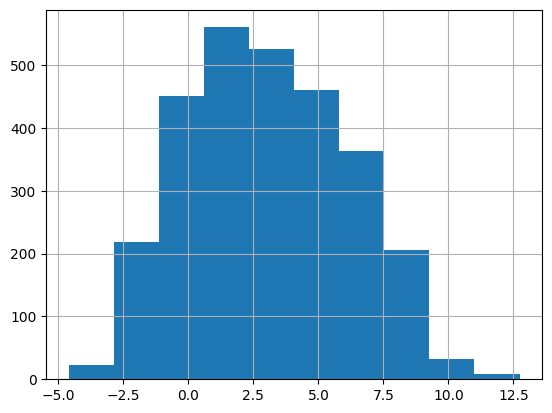

Dataset:  Arachidonate


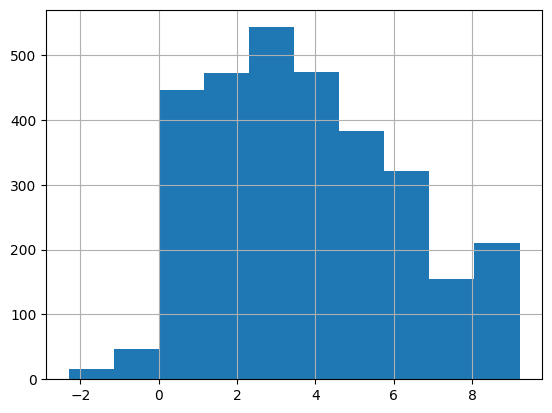

Dataset:  ATR


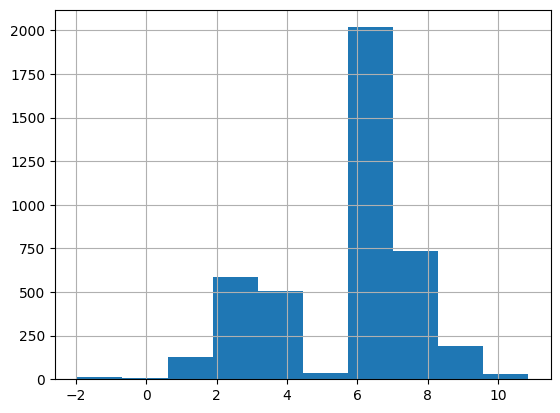

Dataset:  JAK1


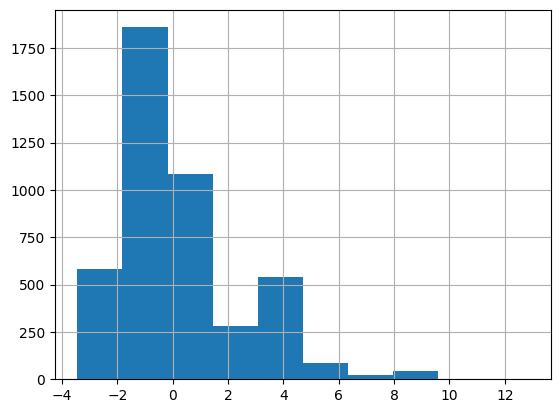

Dataset:  JAK2


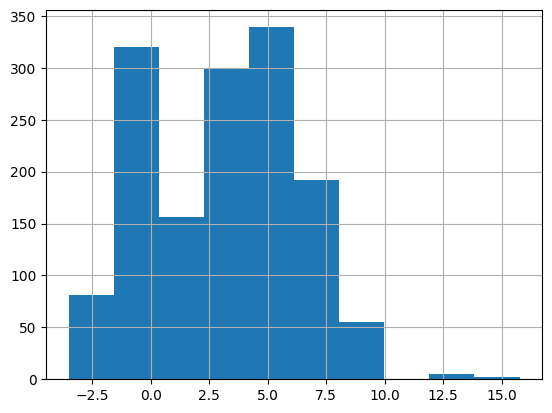

Dataset:  MUSC1


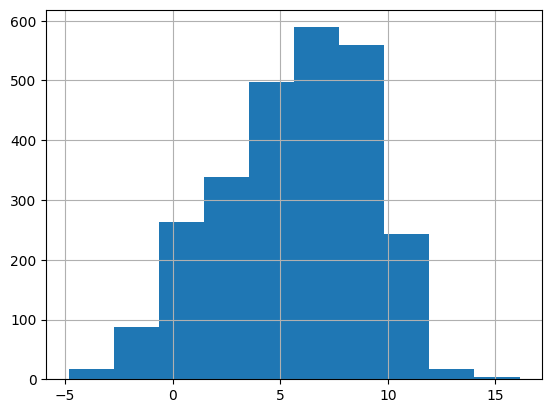

Dataset:  MUSC2


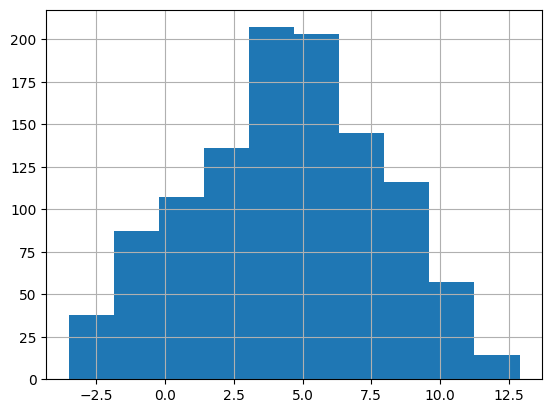

Dataset:  KAPPA


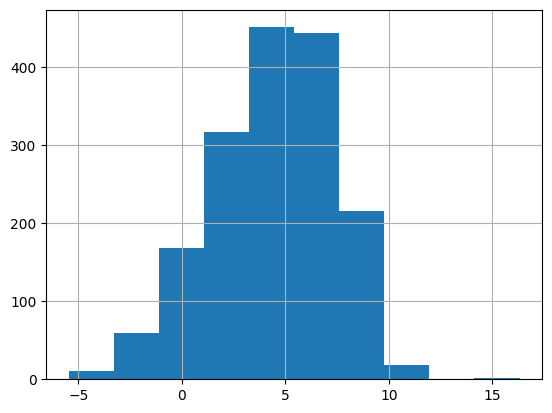

Dataset:  LIPO


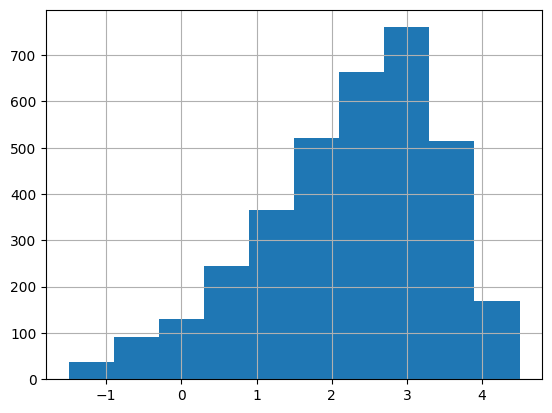

Dataset:  HLMC


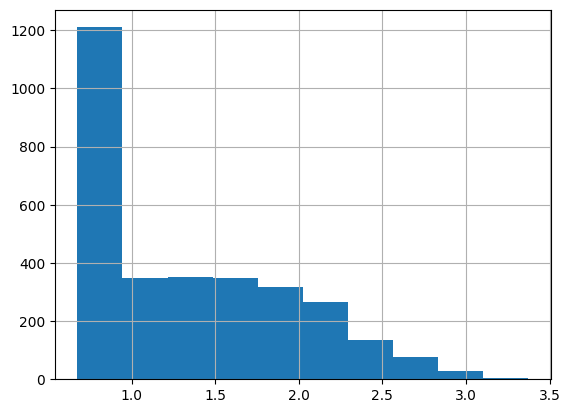

Dataset:  SOL


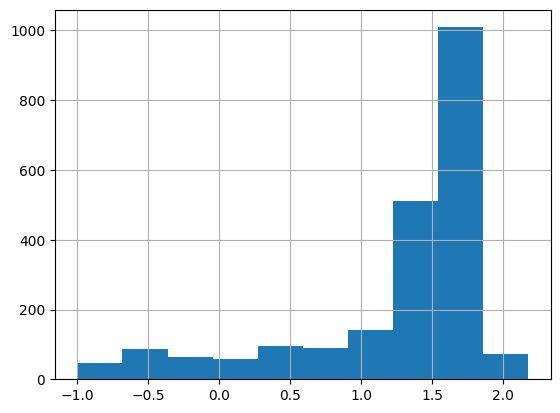

Dataset:  DPP4


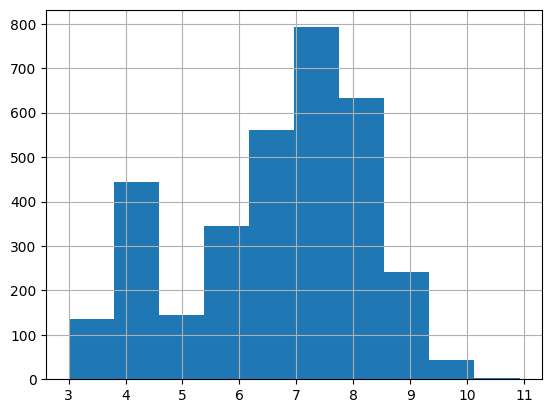

In [10]:
import matplotlib.pyplot as plt
for (d, i), da  in zip(datasets, ["Alpha-1A", "Arachidonate", "ATR", "JAK1", "JAK2", "MUSC1", "MUSC2", "KAPPA", "LIPO", "HLMC", "SOL", "DPP4"]):
    print("Dataset: ", da)
    d["target"].hist()
    plt.show()
       